# Interferometry Basics

You should have completed reading the `olivia_beamforming.ipynb` before reading this python notebook, as we will be now taking the beamformed equation and putting it in the context of radio interferometry.

It is reccomended that you read: Thompson, A.R., Moran, J.M. and Swenson Jr., G.W. (2017) Interferometry and synthesis in radio astronomy. Third edition. Cham: Springer Open (Astronomy and astrophysics library).

## Part 0: Setup

### 0.1: Importing Python Code

In [1]:
from __future__ import print_function, division
import os
import matplotlib.colors as colors
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.fft import ifftn, ifftshift
from scipy.signal import convolve
import pandas as pd

save_results_to = './interferometry practice'

### 0.2: Other Handy Functions

In [2]:
def cartesian_config(x, y):
    ax = plt.gca()  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.set_xlabel(x, x=1.03)
    ax.set_ylabel(y, y=-0.02, rotation=0)

### 0.3: MWA Tile Data

In [3]:
locations = pd.read_csv('./MWA locations.csv')
MWA_x = locations['m East'].tolist()
MWA_y = locations['m North'].tolist()

### 0.4: Our Beamforming Function and Output

We will be using the MWA beam constructed from an array of 16 antennas evenly distributed in a 4 m x 4 m square.

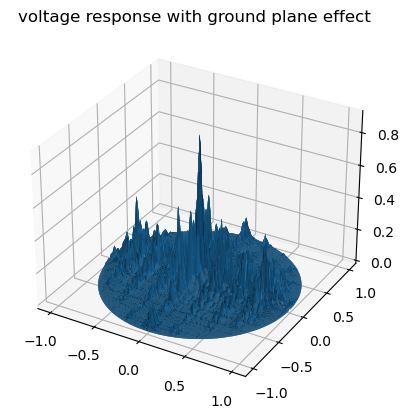

In [4]:
def beamformer(delta=[0,0], f=150*10**6):
    theta = np.deg2rad(np.arange(-90, 90))
    phi = np.deg2rad(np.arange(-180, 180))
    [theta, phi] = np.meshgrid(theta, phi)

    lamda = ((3*10**8)/f)
    beta = (2*np.pi/lamda)

    # Arrange 16 MWA antennas in a 4 m x 4 m square
    n = 16
    u, v = (lambda x: np.meshgrid(x, x))(np.linspace(-2, 2, 4))
    u = u.flatten()
    v = v.flatten()

    l = np.sin(theta)*np.cos(phi)
    m = np.sin(phi)*np.sin(theta)

    # We now consider things in two dimensions
    chix = beta*np.array([l * dn for dn in u]) + delta[0]  # X-phase difference
    chiy = beta*np.array([m * dn for dn in v]) + delta[1]  # Y-phase difference

    afx = 1
    afy = 1

    for i in range(n):
        chinx = chix[i]
        chiny = chiy[i]

        afx = afx + np.exp(1j*(i+1)*chinx)
        afy = afy + np.exp(1j*(i+1)*chiny)

    af = afx*afy/n**2

    # Ground plane effect
    antenna_height = 0.3
    h = antenna_height/lamda
    ground_plane_effect = np.sin(2*h*np.pi*np.cos(theta))

    total_voltage = af*ground_plane_effect

    return l, m, total_voltage

l, m, total_voltage = beamformer()

# 3D plot of voltage response with the ground plane effect.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, np.abs(total_voltage), rstride=1, cstride=1, antialiased=True)
plt.title('voltage response with ground plane effect')
plt.show()


default_beam = total_voltage
beam_x = l
beam_y = m
Vp = default_beam[90][90]

## Part 1: 1-D Interferometry

### 1.1: A Single Baseline and Point Source

First, we consider two radio interferometers seperated by a standard distance. We will place our point source at the source refrence point - meaning that there will be no complex component to the output voltage.

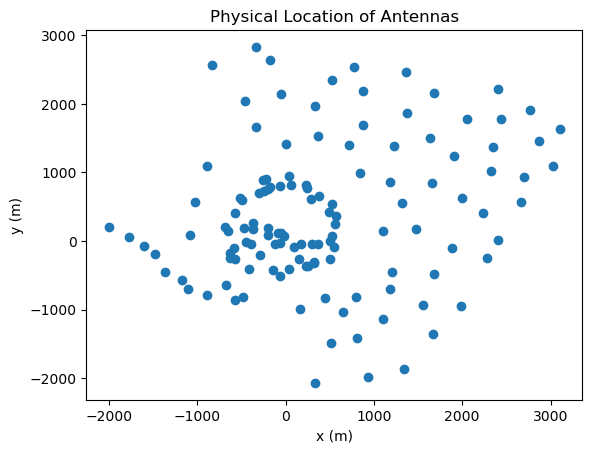

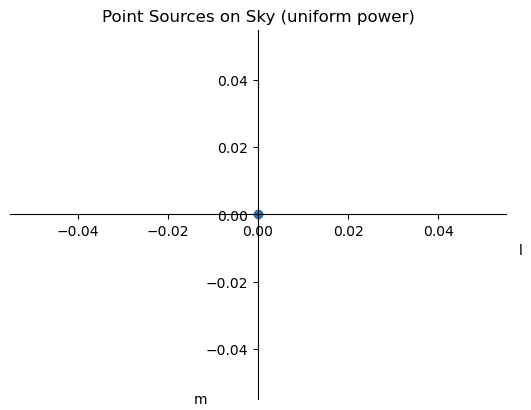

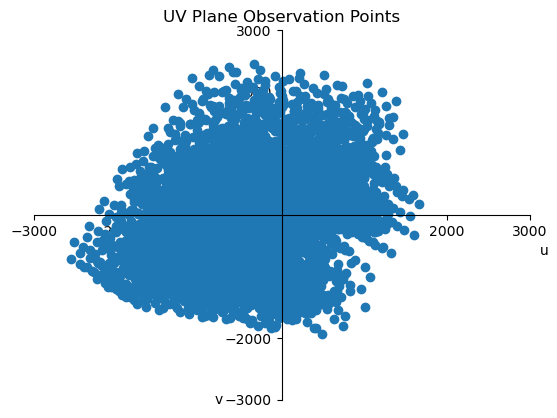

In [5]:
Range = [3000, 3000]

# Define the wavelength that we are attempting to analyse
f = 150*10**6
lamda = 3*10**8/f

# Our baseline will appear as two points on the UV plane, let's seperate the two antennas apart by 1 km
xs = MWA_x
ys = MWA_y
n = len(xs)

plt.plot(xs, ys, 'o')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title("Physical Location of Antennas")
plt.show()

# Place a 10 Jy point source at the refrence position, which maximises our voltage
S = [10]

# These voltages are at the source refrence point so we assume a central position in the (l, m) plane
L = [0]
M = [0]

# In the full calculations V0 is equal to beamform(l, m) for each point source (l, m)
V = Vp*np.ones(n)

plt.plot(L, M, 'o')
cartesian_config('l', 'm')
plt.title("Point Sources on Sky (uniform power)")
plt.show()

# We can then create the array of baseline vectors corresponding to UV plane points and their strengths
u = []
v = []

# We can use the same loop to efficiently evaluate the received power at each point
w = []

for n1 in range(n):
    # To avoid double-covers we need to dynamically define the n2 selections
    for n2 in range(n1, n):
        x1 = xs[n1]
        y1 = ys[n1]
        x2 = xs[n2]
        y2 = ys[n2]

        # We ignore baselines that are zero (i.e. same detector)
        if (x1 == x2) and (y1 == y2):
            continue

        #print(n1, n2)

        # Calculate baseline vectors
        uj =(x1-x2)/lamda
        vj = (y1-y2)/lamda

        # Add the forward direction baseline to list of UV plane points
        u.append(uj)
        v.append(vj)

        # NB: We ignore backwards-direction baselines
        # Add the backwards direction baseline to list of UV plane points
        #u.append(-uj)
        #v.append(-vj)

        # NB: What counts as 'forwards' and 'backwards' here is irrelevant. What matters is that we are adding two mirrored vectors to the array

        # We can finally calculate the received response per baseline Vn Vm*
        Vtot = 0
        for i in range(len(S)):
            Vtot = Vtot + V[n1] * np.conj(V[n2]) * S[i] * np.exp(-2*np.pi*1j*(L[i]*uj+M[i]*vj))
        w.append(Vtot)
                    

u = np.array(u)
v = np.array(v)
w = np.array(w)

plt.plot(u, v, 'o')
plt.title("UV Plane Observation Points")
cartesian_config('u', 'v')
plt.xlim((-Range[0], Range[0]))
plt.ylim((-Range[1], Range[1]))
plt.show()

Now that we have constructed the UV plane we can reverse calculate an image, note that it will not be the most accurate due to it being only 1 point.

In [6]:
# Construct the LM plane
xlim = Range[0]*2
ylim = Range[1]*2
lmpln = np.zeros((xlim, ylim)) +0j

for i in range(len(u)):
    ux = int(np.abs(np.round(u[i])))
    vy = int(np.abs(np.round(v[i])))
    neg = lambda x, lim: 0 if not x else lim-x # We need the opposing baseline value, which is the complex conjugate
    lmpln[ux, vy] = lmpln[ux, vy] + w[i]
    lmpln[neg(ux, xlim), neg(vy, ylim)] = lmpln[neg(ux, xlim), neg(vy, ylim)] + np.conj(w[i])

print(np.sum(lmpln))

img = ifftn(lmpln)

(135595.3307145777+0j)


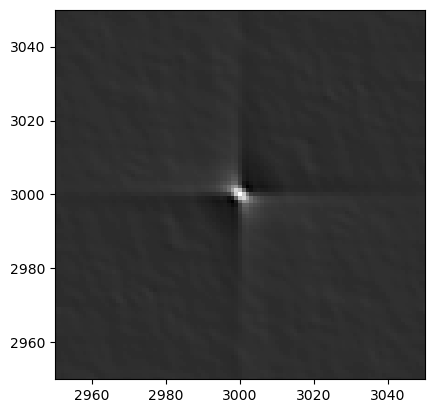

In [11]:
#smrpln = np.ones((100, 100)) +0j

#img_smear = convolve(img, smrpln, method='fft')

plt.imshow(np.real(ifftshift(img)), cmap=cm.gray)
plt.xlim(xlim/2-50, xlim/2+50)
plt.ylim(ylim/2-50, ylim/2+50)
plt.show()
